Create primal dual evolution plots similar to DeepMind paper https://arxiv.org/pdf/2012.13349.pdf 

In [1]:
%load_ext autoreload
%autoreload

from retro_branching.utils import get_most_recent_checkpoint_foldername, sns_plot_val_line

import glob
import gzip
import pickle
from collections import defaultdict
import copy
import numpy as np
import scipy.stats as st
import math

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tabulate import tabulate

# Config

- `agent_to_path` (*dict*): Dictionary mapping what you want your agent(s) to be labelled as in the plots' legends to where to load the validation log.pkl file of the agent in question.
- `evolution_metric_decimals` (*int*): How many decimal places to round the calibrated evolution_metric to when creating evolution_metric bins. This is needed in order to gather multiple gap values into the same evolution_metric bin to take their mean. A higher value will give greater resolution, but may produce noisy graphs and make general trends difficult to identify.
- `verbose` (*bool*): Whether to display the current state of the data frame at each data manipulation stage in the core script. Is useful for debugging and sanity checking.

In [33]:
# # 100x100
agent_to_path = {'RL': '/scratch/datasets/retro_branching/instances/set_cover_nrows_100_ncols_100_density_005_threshold_None/baselines/dqn_gnn_1094_checkpoint_108/rl_validator/rl_validator_1/',
                 'SL': '/scratch/datasets/retro_branching/instances/set_cover_nrows_100_ncols_100_density_005_threshold_None/baselines/gnn_341_checkpoint_120/rl_validator/rl_validator_1/'}
evolution_metric_decimals = 3 # how to round calibrated evolution_metric to create evolution_metric bins so can get mean gap at each evolution_metric point
# evolution_metric_decimals = 0


# # # 500x1000
# agent_to_path = {'RL': '/scratch/datasets/retro_branching/instances/set_cover_nrows_500_ncols_1000_density_005_threshold_None/baselines/dqn_gnn_1236_checkpoint_457/rl_validator/rl_validator_1/',
#                  'SL': '/scratch/datasets/retro_branching/instances/set_cover_nrows_500_ncols_1000_density_005_threshold_None/baselines/gnn_343_checkpoint_233/rl_validator/rl_validator_1/'}
# agent_to_path = {'RL': '/scratch/datasets/retro_branching/instances/set_cover_nrows_500_ncols_1000_density_005_threshold_None/baselines/dqn_gnn_1094_checkpoint_108/rl_validator/rl_validator_1/',
#                  'SL': '/scratch/datasets/retro_branching/instances/set_cover_nrows_500_ncols_1000_density_005_threshold_None/baselines/gnn_341_checkpoint_120/rl_validator/rl_validator_1/'}
# evolution_metric_decimals = 1 # how to round calibrated evolution_metric so can get mean gap at each evolution_metric point


# evolution_metric = 'elapsed_calibrated_solve_time'
evolution_metric = 'lp_iterations'

if evolution_metric == 'lp_iterations':
    evolution_metric_decimals = 0

verbose = True # True False

# Core scripts

Given the above config, these should run without needing to be edited.

In [34]:
# load agent logs
agent_to_log = {}
agent_name_to_display_name = {}
for display_name, path in agent_to_path.items():
    path += get_most_recent_checkpoint_foldername(path)
    with gzip.open(*glob.glob(path+'/*log.pkl'), 'rb') as f:
        log = pickle.load(f)
    agent_name = log['agent_names'][0]
    agent_to_log[agent_name] = log
    agent_name_to_display_name[agent_name] = display_name
    
    print(f'Num evaluation instances solved in {display_name} agent log file: {len(log[agent_name]["num_nodes"])}')

Num evaluation instances solved in RL agent log file: 97
Num evaluation instances solved in SL agent log file: 97


In [35]:
def calc_sol_gap(sol, best_sol, eps=1e-12):
    if sol * best_sol < 0:
        sol_gap = 1
    else:
        if sol > best_sol:
            sol_gap = (sol - best_sol) / max(sol, best_sol, eps)
        else:
            sol_gap = (best_sol - sol) / max(sol, best_sol, eps)
    return sol_gap

def calc_sol_gaps(sols, best_sols):
    if type(best_sols) != list:
        return [calc_sol_gap(sol, best_sols) for sol in sols]
    else:
        return [calc_sol_gap(sol, best_sol) for sol, best_sol in zip(sols, best_sols)]

In [36]:
# get elapsed calibrated solve evolution_metric and gaps
agent_to_stats = {agent: defaultdict(lambda: None) for agent in agent_to_log.keys()}
for agent, log in agent_to_log.items():
    if evolution_metric == 'elapsed_calibrated_solve_time':
        agent_to_stats[agent]['evolution_metric'] = [np.cumsum(elapsed_time) for elapsed_time in log[agent]['elapsed_calibrated_solve_time']]
    elif evolution_metric == 'lp_iterations':
        agent_to_stats[agent]['evolution_metric'] = [np.cumsum(np.abs(lp_iters)) for lp_iters in log[agent]['lp_iterations']]
    agent_to_stats[agent]['primal_gaps'] = [calc_sol_gaps(primals, primals[-1]) for primals in log[agent]['primal_bound']]
    agent_to_stats[agent]['dual_gaps'] = [calc_sol_gaps(duals, duals[-1]) for duals in log[agent]['dual_bound']]
    agent_to_stats[agent]['primal_dual_gaps'] = [calc_sol_gaps(primals, duals) for primals, duals in zip(log[agent]['primal_bound'], log[agent]['dual_bound'])]

In [37]:
# map each step to instance it was in and flatten stats arrays for plotting
for agent in agent_to_stats.keys():
    stats = agent_to_stats[agent]
    # index each step to its instance
    stats['instance'] = []
    for stat in stats.keys():
        if stat != 'instance':
            if len(stats['instance']) == 0:
                for idx in range(len(stats[stat])):
                    for _ in range(len(stats[stat][idx])):
                        stats['instance'].append(idx)
            stats[stat] = [item for sublist in stats[stat] for item in sublist]

In [38]:
# Create dataframes (from above dict) for data manipulation and seaborn plotting (use display_name for legends)
_df = defaultdict(list)
for agent in agent_to_stats.keys():
    for stat in agent_to_stats[agent].keys():
        for el in agent_to_stats[agent][stat]:
            _df[stat].append(el)

for agent in agent_to_stats.keys():
    for _ in range(len(agent_to_stats[agent]['evolution_metric'])):
        _df['Agent'].append(agent_name_to_display_name[agent])
                
df = pd.DataFrame(_df)
if verbose:
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+--------------------+---------------+-------------+--------------------+------------+---------+
|   evolution_metric |   primal_gaps |   dual_gaps |   primal_dual_gaps |   instance | Agent   |
|--------------------+---------------+-------------+--------------------+------------+---------|
|                  2 |    0          | 0.00422535  |         0.00422535 |          0 | RL      |
|                 10 |    0          | 0           |         0          |          0 | RL      |
|                  3 |    0          | 0.00714286  |         0.00714286 |          1 | RL      |
|                  7 |    0          | 0           |         0          |          1 | RL      |
|                  4 |    0.0138568  | 0.00702576  |         0.0207852  |          2 | RL      |
|                 26 |    0.0138568  | 0.00312256  |         0.0169361  |          2 | RL      |
|                 34 |    0          | 0           |         0          |          2 | RL      |
|                  5 |    0   

In [39]:
# group data into evolution_metric bins so can calc mean gap at each evolution_metric bin
max_evolution_metric = max(df['evolution_metric'])
if evolution_metric_decimals == 0:
    num_bins = math.ceil(max_evolution_metric)
else:
    num_bins = math.ceil(max_evolution_metric / 10**(-evolution_metric_decimals))

bins = 10**(-evolution_metric_decimals) * np.arange(0, num_bins+1)

grouped_evolution_metric = bins[:-1]

df['grouped_evolution_metric'] = pd.cut(df['evolution_metric'], bins=bins, labels=grouped_evolution_metric)
if verbose:
    print(f'num_bins: {num_bins}')
    print(f'evolution_metric_bins: {bins}')
    print(f'bin labels: {grouped_evolution_metric}')
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=True))

num_bins: 133
evolution_metric_bins: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133]
bin labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 

In [40]:
# for any rows with multiple entries for the same evolution_metric bin in a given instance, remove the rows up to the 
# final row, since agent was able to close the gap up to the final gap value within the set evolution_metric bin

_df = copy.deepcopy(df)
prev_instance = None
df_idx = 0
for idx, instance in enumerate(_df['instance']):
    if prev_instance == instance:
        # still on same instance
        if idx > 0:
            if _df['grouped_evolution_metric'][idx] == _df['grouped_evolution_metric'][idx-1]:
                # repeated grouped evolution_metric, remove previous row
                df = df.drop(labels=df_idx-1, axis=0)
    prev_instance = copy.deepcopy(instance)
    df_idx += 1
df = df.reset_index() # reset indices since drop so can properly index again
df = df.drop(labels='index', axis=1) # remove annoying index column for below visualisation of dataframe
if verbose:
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=True))

+-----+--------------------+---------------+-------------+--------------------+------------+---------+----------------------------+
|     |   evolution_metric |   primal_gaps |   dual_gaps |   primal_dual_gaps |   instance | Agent   |   grouped_evolution_metric |
|-----+--------------------+---------------+-------------+--------------------+------------+---------+----------------------------|
|   0 |                  2 |    0          | 0.00422535  |         0.00422535 |          0 | RL      |                          1 |
|   1 |                 10 |    0          | 0           |         0          |          0 | RL      |                          9 |
|   2 |                  3 |    0          | 0.00714286  |         0.00714286 |          1 | RL      |                          2 |
|   3 |                  7 |    0          | 0           |         0          |          1 | RL      |                          6 |
|   4 |                  4 |    0.0138568  | 0.00702576  |         0.0207852

In [41]:
# Fill in grouped_evolution_metric up to max_grouped_evolution_metric for each instance so all instances have same length


def insert_rows_in_df(df, new_df, instance, new_df_offset, grouped_evolution_metric_to_add, evolution_metric_decimals):
    # fix any python floating point arithmetic errors
    grouped_evolution_metric_to_add = [round(t, evolution_metric_decimals) for t in grouped_evolution_metric_to_add]
    
    # get instance index in new_df
    new_df_indices = new_df.index[new_df['instance'] == instance].tolist()
    for new_df_idx in new_df_indices:
        if new_df['Agent'][new_df_idx] == agent and new_df['evolution_metric'][new_df_idx] == df['evolution_metric'][idx]:
            # found new_df idx to insert values
            break
        else:
            # not current agent or curr evolution_metric, move to next
            pass
    for i in range(len(grouped_evolution_metric_to_add)):
        values = []
        for header in df.columns:
            if header == 'grouped_evolution_metric' or header == 'evolution_metric':
                values.append(grouped_evolution_metric_to_add[i])
            else:
                values.append(df[header][idx])
        new_df = pd.DataFrame(np.insert(new_df.values, new_df_idx+new_df_offset+i, values=values, axis=0), columns=df.columns)
    return new_df
        
    
    

max_grouped_evolution_metric = max(df['grouped_evolution_metric'])
new_df = copy.deepcopy(df)
prev_instance = None
for idx in range(len(df['instance'])):
    instance = df['instance'][idx]
    curr_evolution_metric, agent = df['grouped_evolution_metric'][idx], df["Agent"][idx]
    if verbose:
        print(f'\n>> instance: {instance} | idx: {idx} | curr_evolution_metric: {curr_evolution_metric} | agent: {agent} <<')
    
    # use an idx+adder trick so do not get IndexError for last instance in column
    if idx < len(df['instance'])-1:
        adder = 1
    else:
        adder = 0
        
    # 1. check if need to insert rows before current row
    new_df_offset = 0 # insert before current row
    if instance != prev_instance:
        # new instance, add grouped evolution_metric up to first recorded grouped evolution_metric
        if verbose:
            print('new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric')
        start_grouped_evolution_metric = df['grouped_evolution_metric'][idx]
        num_rows_to_add = round(start_grouped_evolution_metric / 10**(-evolution_metric_decimals), 0)
        grouped_evolution_metric_to_add = 10**(-evolution_metric_decimals) * np.arange(0, num_rows_to_add)
        if verbose:
            print('making insertions into new_df with params:')
            print(f' new_df_offset: {new_df_offset}')
            print(f' num_rows_to_add: {num_rows_to_add}')
            print(f' grouped_evolution_metric_to_add: {grouped_evolution_metric_to_add}')
        new_df = insert_rows_in_df(df, new_df, instance, new_df_offset, grouped_evolution_metric_to_add, evolution_metric_decimals)
        
    # 2. check if need to insert rows after current row
    new_df_offset = 1 # insert after current row
    if df['instance'][idx+adder] == instance and adder != 0:
        # next row is part of same instance, check next row's evolution_metric value
        next_evolution_metric = df['grouped_evolution_metric'][idx+adder]
        if curr_evolution_metric + 10**(-evolution_metric_decimals) == next_evolution_metric:
            # next row has next grouped evolution_metric given evolution_metric_decimals resolution, no need to fill table
            if verbose:
                print(f'next row has next grouped evolution_metric, no need to fill table')
            grouped_evolution_metric_to_add = []
        else:
            # missing grouped evolution_metric rows, need to fill table up to next recorded grouped evolution_metric
            if verbose:
                print('missing grouped rows, need to fill table up to next recorded grouped evolution_metric')
            num_rows_to_add = round((next_evolution_metric - curr_evolution_metric) / 10**(-evolution_metric_decimals), 0) - 1
            start = (curr_evolution_metric / (10**(-evolution_metric_decimals))) + 1
            grouped_evolution_metric_to_add = 10**(-evolution_metric_decimals) * np.arange(start, num_rows_to_add+start)
            if verbose:
                print('making insertions into new_df with params:')
                print(f' new_df_offset: {new_df_offset}')
                print(f' num_rows_to_add: {num_rows_to_add}')
                print(f' grouped_evolution_metric_to_add: {grouped_evolution_metric_to_add}')
            new_df = insert_rows_in_df(df, new_df, instance, new_df_offset, grouped_evolution_metric_to_add, evolution_metric_decimals)
    else:
        # next row is end of instance, fill rows up to max evolution_metric
        if verbose:
            print('next row moves to a new instance, need to fill current instance up to max evolution_metric')
        num_rows_to_add = round((max_grouped_evolution_metric - curr_evolution_metric) / 10**(-evolution_metric_decimals), 0)
        start = (curr_evolution_metric / (10**(-evolution_metric_decimals)))+1
        grouped_evolution_metric_to_add = 10**(-evolution_metric_decimals) * np.arange(start, num_rows_to_add+start)
        if verbose:
            print('making insertions into new_df with params:')
            print(f' new_df_offset: {new_df_offset}')
            print(f' num_rows_to_add: {num_rows_to_add}')
            print(f' grouped_evolution_metric_to_add: {grouped_evolution_metric_to_add}')
        new_df = insert_rows_in_df(df, new_df, instance, new_df_offset, grouped_evolution_metric_to_add, evolution_metric_decimals)        

    prev_instance = copy.deepcopy(instance)
    
if verbose:
    print(tabulate(new_df, headers='keys', tablefmt='psql', showindex=True))


>> instance: 0 | idx: 0 | curr_evolution_metric: 1 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 1.0
 grouped_evolution_metric_to_add: [0.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 7.0
 grouped_evolution_metric_to_add: [2. 3. 4. 5. 6. 7. 8.]

>> instance: 0 | idx: 1 | curr_evolution_metric: 9 | agent: RL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 123.0
 grouped_evolution_metric_to_add: [ 10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.
  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.
  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51


>> instance: 6 | idx: 11 | curr_evolution_metric: 12 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 12.0
 grouped_evolution_metric_to_add: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 3.0
 grouped_evolution_metric_to_add: [13. 14. 15.]

>> instance: 6 | idx: 12 | curr_evolution_metric: 16 | agent: RL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 4.0
 grouped_evolution_metric_to_add: [17. 18. 19. 20.]

>> instance: 6 | idx: 13 | curr_evolution_metric: 21 | agent: RL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric

missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 8.0
 grouped_evolution_metric_to_add: [12. 13. 14. 15. 16. 17. 18. 19.]

>> instance: 12 | idx: 22 | curr_evolution_metric: 20 | agent: RL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 112.0
 grouped_evolution_metric_to_add: [ 21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.
  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.
  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.
  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.
  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.
  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104.
 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 1


>> instance: 19 | idx: 36 | curr_evolution_metric: 3 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 3.0
 grouped_evolution_metric_to_add: [0. 1. 2.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 8.0
 grouped_evolution_metric_to_add: [ 4.  5.  6.  7.  8.  9. 10. 11.]

>> instance: 19 | idx: 37 | curr_evolution_metric: 12 | agent: RL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 5.0
 grouped_evolution_metric_to_add: [13. 14. 15. 16. 17.]

>> instance: 19 | idx: 38 | curr_evolution_metric: 18 | agent: RL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions 


>> instance: 25 | idx: 49 | curr_evolution_metric: 3 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 3.0
 grouped_evolution_metric_to_add: [0. 1. 2.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 6.0
 grouped_evolution_metric_to_add: [4. 5. 6. 7. 8. 9.]

>> instance: 25 | idx: 50 | curr_evolution_metric: 10 | agent: RL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 122.0
 grouped_evolution_metric_to_add: [ 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50. 


>> instance: 33 | idx: 64 | curr_evolution_metric: 3 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 3.0
 grouped_evolution_metric_to_add: [0. 1. 2.]
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 129.0
 grouped_evolution_metric_to_add: [  4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.
  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.


>> instance: 39 | idx: 75 | curr_evolution_metric: 3 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 3.0
 grouped_evolution_metric_to_add: [0. 1. 2.]
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 129.0
 grouped_evolution_metric_to_add: [  4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.
  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.


>> instance: 45 | idx: 87 | curr_evolution_metric: 11 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 11.0
 grouped_evolution_metric_to_add: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 121.0
 grouped_evolution_metric_to_add: [ 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.
  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.
  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.
  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.
  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.
  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.
  96.  97.  98.  99. 100. 101. 10


>> instance: 51 | idx: 101 | curr_evolution_metric: 8 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 8.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3. 4. 5. 6. 7.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 3.0
 grouped_evolution_metric_to_add: [ 9. 10. 11.]

>> instance: 51 | idx: 102 | curr_evolution_metric: 12 | agent: RL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 120.0
 grouped_evolution_metric_to_add: [ 13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.


>> instance: 58 | idx: 109 | curr_evolution_metric: 4 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 4.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 7.0
 grouped_evolution_metric_to_add: [ 5.  6.  7.  8.  9. 10. 11.]

>> instance: 58 | idx: 110 | curr_evolution_metric: 12 | agent: RL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 120.0
 grouped_evolution_metric_to_add: [ 13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49. 


>> instance: 64 | idx: 124 | curr_evolution_metric: 5 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 5.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3. 4.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 6.0
 grouped_evolution_metric_to_add: [ 6.  7.  8.  9. 10. 11.]

>> instance: 64 | idx: 125 | curr_evolution_metric: 12 | agent: RL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 120.0
 grouped_evolution_metric_to_add: [ 13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  


>> instance: 70 | idx: 137 | curr_evolution_metric: 7 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 7.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3. 4. 5. 6.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 12.0
 grouped_evolution_metric_to_add: [ 8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]

>> instance: 70 | idx: 138 | curr_evolution_metric: 20 | agent: RL <<
next row has next grouped evolution_metric, no need to fill table

>> instance: 70 | idx: 139 | curr_evolution_metric: 21 | agent: RL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 17.0
 grouped_evolution_metric_to_add: [22. 23. 24. 25. 26. 27. 28


>> instance: 76 | idx: 151 | curr_evolution_metric: 1 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 1.0
 grouped_evolution_metric_to_add: [0.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 5.0
 grouped_evolution_metric_to_add: [2. 3. 4. 5. 6.]

>> instance: 76 | idx: 152 | curr_evolution_metric: 7 | agent: RL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 9.0
 grouped_evolution_metric_to_add: [ 8.  9. 10. 11. 12. 13. 14. 15. 16.]

>> instance: 76 | idx: 153 | curr_evolution_metric: 17 | agent: RL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions 


>> instance: 81 | idx: 166 | curr_evolution_metric: 27 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 27.0
 grouped_evolution_metric_to_add: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 5.0
 grouped_evolution_metric_to_add: [28. 29. 30. 31. 32.]

>> instance: 81 | idx: 167 | curr_evolution_metric: 33 | agent: RL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 99.0
 grouped_evolution_metric_to_add: [ 34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.  51.  52.  


>> instance: 87 | idx: 178 | curr_evolution_metric: 1 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 1.0
 grouped_evolution_metric_to_add: [0.]
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 131.0
 grouped_evolution_metric_to_add: [  2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.
  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.
 100


>> instance: 94 | idx: 187 | curr_evolution_metric: 6 | agent: RL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 6.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3. 4. 5.]
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 126.0
 grouped_evolution_metric_to_add: [  7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.
  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.
  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.
  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.
  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.
  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.
  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102.


>> instance: 3 | idx: 202 | curr_evolution_metric: 4 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 4.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3.]
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 128.0
 grouped_evolution_metric_to_add: [  5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.
  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.
  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.
  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 1


>> instance: 10 | idx: 212 | curr_evolution_metric: 8 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 8.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3. 4. 5. 6. 7.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 6.0
 grouped_evolution_metric_to_add: [ 9. 10. 11. 12. 13. 14.]

>> instance: 10 | idx: 213 | curr_evolution_metric: 15 | agent: SL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 10.0
 grouped_evolution_metric_to_add: [16. 17. 18. 19. 20. 21. 22. 23. 24. 25.]

>> instance: 10 | idx: 214 | curr_evolution_metric: 26 | agent: SL <<
next row moves to a new instance, need to fill current instance up to max


>> instance: 16 | idx: 229 | curr_evolution_metric: 4 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 4.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 1.0
 grouped_evolution_metric_to_add: [5.]

>> instance: 16 | idx: 230 | curr_evolution_metric: 6 | agent: SL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 126.0
 grouped_evolution_metric_to_add: [  7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.
  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.
  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.
 


>> instance: 23 | idx: 240 | curr_evolution_metric: 12 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 12.0
 grouped_evolution_metric_to_add: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 2.0
 grouped_evolution_metric_to_add: [13. 14.]

>> instance: 23 | idx: 241 | curr_evolution_metric: 15 | agent: SL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 2.0
 grouped_evolution_metric_to_add: [16. 17.]

>> instance: 23 | idx: 242 | curr_evolution_metric: 18 | agent: SL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
makin


>> instance: 30 | idx: 251 | curr_evolution_metric: 6 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 6.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3. 4. 5.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 6.0
 grouped_evolution_metric_to_add: [ 7.  8.  9. 10. 11. 12.]

>> instance: 30 | idx: 252 | curr_evolution_metric: 13 | agent: SL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 119.0
 grouped_evolution_metric_to_add: [ 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50


>> instance: 36 | idx: 265 | curr_evolution_metric: 60 | agent: SL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 21.0
 grouped_evolution_metric_to_add: [61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78.
 79. 80. 81.]

>> instance: 36 | idx: 266 | curr_evolution_metric: 82 | agent: SL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 15.0
 grouped_evolution_metric_to_add: [83. 84. 85. 86. 87. 88. 89. 90. 91. 92. 93. 94. 95. 96. 97.]

>> instance: 36 | idx: 267 | curr_evolution_metric: 98 | agent: SL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 34.0
 grouped_evolution_metric_to_add: [ 99. 100. 101. 102. 


>> instance: 42 | idx: 279 | curr_evolution_metric: 3 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 3.0
 grouped_evolution_metric_to_add: [0. 1. 2.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 6.0
 grouped_evolution_metric_to_add: [4. 5. 6. 7. 8. 9.]

>> instance: 42 | idx: 280 | curr_evolution_metric: 10 | agent: SL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 122.0
 grouped_evolution_metric_to_add: [ 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50


>> instance: 49 | idx: 290 | curr_evolution_metric: 7 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 7.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3. 4. 5. 6.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 22.0
 grouped_evolution_metric_to_add: [ 8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.
 26. 27. 28. 29.]

>> instance: 49 | idx: 291 | curr_evolution_metric: 30 | agent: SL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 6.0
 grouped_evolution_metric_to_add: [31. 32. 33. 34. 35. 36.]

>> instance: 49 | idx: 292 | curr_evolution_metric: 37 | agent: SL <<
missing grouped rows, need 


>> instance: 55 | idx: 302 | curr_evolution_metric: 2 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 2.0
 grouped_evolution_metric_to_add: [0. 1.]
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 130.0
 grouped_evolution_metric_to_add: [  3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.
  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.
  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.
  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100.
 


>> instance: 62 | idx: 312 | curr_evolution_metric: 2 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 2.0
 grouped_evolution_metric_to_add: [0. 1.]
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 130.0
 grouped_evolution_metric_to_add: [  3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.
  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.
  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.
  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100.
 


>> instance: 67 | idx: 328 | curr_evolution_metric: 10 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 10.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 11.0
 grouped_evolution_metric_to_add: [11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21.]

>> instance: 67 | idx: 329 | curr_evolution_metric: 22 | agent: SL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 110.0
 grouped_evolution_metric_to_add: [ 23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.
  51.  52


>> instance: 73 | idx: 343 | curr_evolution_metric: 10 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 10.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 9.0
 grouped_evolution_metric_to_add: [11. 12. 13. 14. 15. 16. 17. 18. 19.]

>> instance: 73 | idx: 344 | curr_evolution_metric: 20 | agent: SL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 6.0
 grouped_evolution_metric_to_add: [21. 22. 23. 24. 25. 26.]

>> instance: 73 | idx: 345 | curr_evolution_metric: 27 | agent: SL <<
next row moves to a new instance, need to fill current instance up to 


>> instance: 79 | idx: 357 | curr_evolution_metric: 11 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 11.0
 grouped_evolution_metric_to_add: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 9.0
 grouped_evolution_metric_to_add: [12. 13. 14. 15. 16. 17. 18. 19. 20.]

>> instance: 79 | idx: 358 | curr_evolution_metric: 21 | agent: SL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 16.0
 grouped_evolution_metric_to_add: [22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.]

>> instance: 79 | idx: 359 | curr_evolution_metric: 38 | agent: SL <<
missing grouped


>> instance: 84 | idx: 377 | curr_evolution_metric: 10 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 10.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 7.0
 grouped_evolution_metric_to_add: [11. 12. 13. 14. 15. 16. 17.]

>> instance: 84 | idx: 378 | curr_evolution_metric: 18 | agent: SL <<
next row has next grouped evolution_metric, no need to fill table

>> instance: 84 | idx: 379 | curr_evolution_metric: 19 | agent: SL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 14.0
 grouped_evolution_metric_to_add: [20. 21. 22. 23. 24. 25. 26. 27. 28. 


>> instance: 90 | idx: 389 | curr_evolution_metric: 8 | agent: SL <<
new instance started, add grouped evolution_metric up to first recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 0
 num_rows_to_add: 8.0
 grouped_evolution_metric_to_add: [0. 1. 2. 3. 4. 5. 6. 7.]
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 8.0
 grouped_evolution_metric_to_add: [ 9. 10. 11. 12. 13. 14. 15. 16.]

>> instance: 90 | idx: 390 | curr_evolution_metric: 17 | agent: SL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 5.0
 grouped_evolution_metric_to_add: [18. 19. 20. 21. 22.]

>> instance: 90 | idx: 391 | curr_evolution_metric: 23 | agent: SL <<
next row moves to a new instance, need to fill current instance up to max evolution_me


>> instance: 95 | idx: 401 | curr_evolution_metric: 105 | agent: SL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 18.0
 grouped_evolution_metric_to_add: [106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123.]

>> instance: 95 | idx: 402 | curr_evolution_metric: 124 | agent: SL <<
missing grouped rows, need to fill table up to next recorded grouped evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 7.0
 grouped_evolution_metric_to_add: [125. 126. 127. 128. 129. 130. 131.]

>> instance: 95 | idx: 403 | curr_evolution_metric: 132 | agent: SL <<
next row moves to a new instance, need to fill current instance up to max evolution_metric
making insertions into new_df with params:
 new_df_offset: 1
 num_rows_to_add: 0.0
 grouped_evolution_metric_to_add: []

>> instance: 96 | idx: 404 | curr_e

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Quick sanity checks

In [42]:
# fix any python floating point arithmetic errors
for idx, t in enumerate(new_df['grouped_evolution_metric']):
    new_df['grouped_evolution_metric'][idx] = round(t, evolution_metric_decimals)

# check if any consequtive evolution_metric are identical
for idx in range(len(new_df)):
    if idx > 0:
        if new_df['grouped_evolution_metric'][idx] == new_df['grouped_evolution_metric'][idx-1]:
            raise Exception(f'Found duplicate evolution_metric at idx {idx}')
            
# check if any consequtive duals within instance do not make sense
prev_instance = None
for idx, instance in enumerate(new_df['instance']):
    if instance == prev_instance:
        if new_df['dual_gaps'][idx] > new_df['dual_gaps'][idx-1]:
            raise Exception(f'Found consequtive steps in instance with increasing dual at idx {idx}')

### Debug zone

Set to `debug = True` if needed :,(

In [43]:
debug = False # True False

In [44]:
if debug:
    print(new_df.head())

    tmp_df = new_df[['dual_gaps', 'instance', 'grouped_evolution_metric']]
    if verbose:
        print(tabulate(tmp_df, headers='keys', tablefmt='psql', showindex=True))

In [45]:
if debug:
    evolution_metric_bin_to_dual_gaps = defaultdict(list)
    instance_to_evolution_metric_bin = {instance: set() for instance in new_df['instance']}
    for idx in range(len(new_df)):
        evolution_metric_bin_to_dual_gaps[new_df['grouped_evolution_metric'][idx]].append(new_df['dual_gaps'][idx])
        if new_df['grouped_evolution_metric'][idx] not in instance_to_evolution_metric_bin[new_df['instance'][idx]]:
            instance_to_evolution_metric_bin[new_df['instance'][idx]].add(new_df['grouped_evolution_metric'][idx])
    for idx, evolution_metric_bin in enumerate(list(evolution_metric_bin_to_dual_gaps.keys())):
        # all evolution_metric bins should have the same (num_agents*num_instances) number of entries
        print(f'evolution_metric bin {evolution_metric_bin} idx {idx} # entries: {len(evolution_metric_bin_to_dual_gaps[evolution_metric_bin])}')
    for instance in instance_to_evolution_metric_bin.keys():
        for t in evolution_metric_bin_to_dual_gaps.keys():
            if t not in instance_to_evolution_metric_bin[instance]:
                print(f'instance {instance} does not contain evolution_metric bin {t} ')

    evolution_metric_bin_to_mean_dual_gap = {evolution_metric_bin: np.mean(dual_gaps) for evolution_metric_bin, dual_gaps in evolution_metric_bin_to_dual_gaps.items()}
    # print(evolution_metric_bin_to_mean_dual_gap)
    print(f'\nevolution_metric bins: {list(evolution_metric_bin_to_mean_dual_gap.keys())}')
    print(f'\ndual gaps: {list(evolution_metric_bin_to_mean_dual_gap.values())}')

    fig = plt.figure()
    plt.plot(list(evolution_metric_bin_to_mean_dual_gap.keys()), list(evolution_metric_bin_to_mean_dual_gap.values()))
    plt.show()

    dual_gaps = list(evolution_metric_bin_to_mean_dual_gap.values())
    for idx, dual_gap in enumerate(dual_gaps):
        if idx > 0:
            if dual_gaps[idx] > dual_gaps[idx-1]:
                raise Exception(f'inconsistent at idx {idx}, goes from dual gap {dual_gaps[idx-1]} to {dual_gaps[idx]}')

    for idx, t in enumerate(list(evolution_metric_bin_to_mean_dual_gap.keys())):
        if t != round(idx * 10**(-evolution_metric_decimals), evolution_metric_decimals):
            raise Exception(f'evolution_metric {t} at idx {idx} inconsistent')

# Plots

In [52]:
# config

estimator = 'mean'
# estimator = np.median
# estimator = np.mode
# estimator = None

context = 'paper'
style = 'whitegrid'
font_scale = 2
palette = 'hls'
ci = 68
errcolor = 'gray'
capsize = 0.05
fig_size = (7.5, 3)

xlog = True # False True
ylog = True # False True

if evolution_metric == 'elapsed_calibrated_solve_time':
    xlabel = 'Cal. Time (s)'
elif evolution_metric == 'lp_iterations':
    xlabel = '# LP Iterations'
else:
    raise Exception(f'Unrecognised xlabel evolution_metric {evolution_metric}')

In [53]:
# ensure dataframe entries are numerical types for seaborn plotting
for col in new_df.columns:
    try:
        new_df[col] = pd.to_numeric(new_df[col])
    except ValueError:
        # cannot convert string to numerical type
        pass

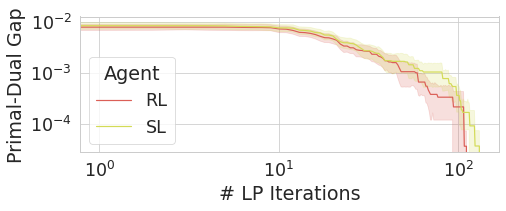

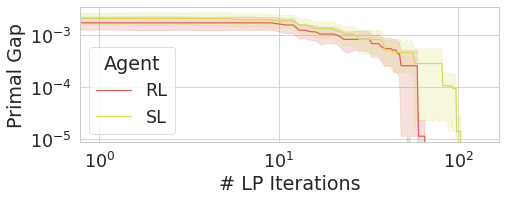

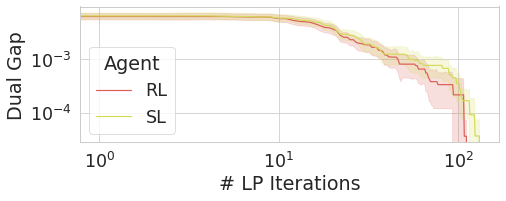

In [54]:
sns.set_theme(font_scale=font_scale,
              context=context,
              style=style,
              palette=palette)

f, ax = plt.subplots(figsize=fig_size)
g = sns.lineplot(data=new_df, x='grouped_evolution_metric', y='primal_dual_gaps', hue='Agent', estimator=estimator, ci=ci)
g.set_xlabel(xlabel)
g.set_ylabel('Primal-Dual Gap')
if xlog:
    g.set(xscale='log')
if ylog:
    g.set(yscale='log')
plt.show()

f, ax = plt.subplots(figsize=fig_size)
g = sns.lineplot(data=new_df, x='grouped_evolution_metric', y='primal_gaps', hue='Agent', estimator=estimator, ci=ci)
g.set_xlabel(xlabel)
g.set_ylabel('Primal Gap')
if xlog:
    g.set(xscale='log')
if ylog:
    g.set(yscale='log')
plt.show()

f, ax = plt.subplots(figsize=fig_size)
g = sns.lineplot(data=new_df, x='grouped_evolution_metric', y='dual_gaps', hue='Agent', estimator=estimator, ci=ci)
g.set_xlabel(xlabel)
g.set_ylabel('Dual Gap')
if xlog:
    g.set(xscale='log')
if ylog:
    g.set(yscale='log')
plt.show()